In [1]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [2]:
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
min_len = 200
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 236
stopping at sequence of length 236
236 torch.Size([236, 12]) tensor(False)
paddings:  13 tensor(13)


### Load joblib file

In [6]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#             "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/344_aas_seq_and_angles.joblib")
info = joblib.load("experiments/344_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [7]:
from massive_pnerf import *

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [9]:
# featurize
scaffolds = build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [10]:
scaffolds["angles_mask"][0, 0, 2], angles[0,3]

(tensor(1.9124), tensor(1.9124))

In [11]:
# %%timeit
# convert coords - fold
coords, mask = proto_fold(seq[:-padding_seq], **scaffolds)
coords_flat  = rearrange(coords, 'l c d -> (l c) d') 

right destin tensor([[ 0.5632,  0.2680,  0.7817],
        [ 0.0964,  0.9182, -0.3842],
        [-0.8207,  0.2918,  0.4913]])
modified destin tensor([[ 0.3982,  0.1895,  0.5527],
        [ 0.0964,  0.9182, -0.3842],
        [-0.5803,  0.2063,  0.3474]])
right destin tensor([[ 0.2515,  0.6624, -0.7057],
        [ 0.9568, -0.2798,  0.0784],
        [-0.1455, -0.6949, -0.7042]])
modified destin tensor([[ 0.1779,  0.4684, -0.4990],
        [ 0.9568, -0.2798,  0.0784],
        [-0.1029, -0.4914, -0.4979]])
right destin tensor([[ 0.8800,  0.0845,  0.4673],
        [-0.0198,  0.9897, -0.1416],
        [-0.4745,  0.1154,  0.8727]])
modified destin tensor([[ 0.6223,  0.0597,  0.3305],
        [-0.0198,  0.9897, -0.1416],
        [-0.3355,  0.0816,  0.6171]])
right destin tensor([[-0.0365,  0.7985, -0.6009],
        [ 0.8180, -0.3216, -0.4770],
        [-0.5741, -0.5090, -0.6414]])
modified destin tensor([[-0.0258,  0.5646, -0.4249],
        [ 0.8180, -0.3216, -0.4770],
        [-0.4059, -0.3599,

right destin tensor([[-0.1951, -0.9737, -0.1180],
        [ 0.1232,  0.0950, -0.9878],
        [ 0.9730, -0.2073,  0.1014]])
modified destin tensor([[-0.1380, -0.6885, -0.0835],
        [ 0.1232,  0.0950, -0.9878],
        [ 0.6880, -0.1466,  0.0717]])
right destin tensor([[-0.8549,  0.2009,  0.4784],
        [-0.3826,  0.3787, -0.8427],
        [-0.3505, -0.9034, -0.2469]])
modified destin tensor([[-0.6045,  0.1421,  0.3383],
        [-0.3826,  0.3787, -0.8427],
        [-0.2478, -0.6388, -0.1746]])
right destin tensor([[ 0.7137,  0.5020,  0.4885],
        [-0.1596,  0.7956, -0.5844],
        [-0.6821,  0.3391,  0.6479]])
modified destin tensor([[ 0.5046,  0.3550,  0.3454],
        [-0.1596,  0.7956, -0.5844],
        [-0.4823,  0.2398,  0.4581]])
right destin tensor([[ 0.3525, -0.9043, -0.2408],
        [ 0.5781,  0.4127, -0.7039],
        [ 0.7359,  0.1089,  0.6683]])
modified destin tensor([[ 0.2492, -0.6394, -0.1702],
        [ 0.5781,  0.4127, -0.7039],
        [ 0.5204,  0.0770,

#### Profiling

In [14]:
%load_ext snakeviz
%snakeviz proto_fold(seq[:-padding_seq], **scaffolds)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/var/folders/lh/zgndpx8x755_lcsq48lp_5t40000gn/T/tmpr0w1rabo'. 
Embedding SnakeViz in this document...


#### Display

In [12]:
true_coords.shape, len(int_seq[:-padding_angles-1]), seq

(torch.Size([4816, 3]),
 330,
 'MKVLCYGVRDVELPIFEACNKEFGYDIKCVPDYLNTKETAEMAAGFDAVILRGNCFANKQNLDIYKKLGVKYILTRTAGTDHIDKEYAKELGFPMAFVPRYSPNAIAELAVTQAMMLLRHTAYTTSRTAKKNFKVDAFMFSKEVRNCTVGVVGLGRIGRVAAQIFHGMGATVIGEDVFEIKGIEDYCTQVSLDEVLEKSDIITIHAPYIKENGAVVTRDFLKKMKDGAILVNCARGQLVDTEAVIEAVESGKLGGYGCDVLDGEASVFGKDLEGQKLENPLFEKLVDLYPRVLITPHLGSYTDEAVKNMVEVSYQNLKDLAETGDCPNKIK_____________')

In [12]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
sb = sidechainnet.StructureBuilder(int_seq[:-padding_angles], crd=true_coords[:-14*padding_angles]) # coords_flat
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Diagnose rotation matrix

In [19]:
# Standard import
import matplotlib.pyplot as plt
# Import 3D Axes 
from mpl_toolkits.mplot3d import axes3d

In [20]:
# %matplotlib notebook

#### True backbone

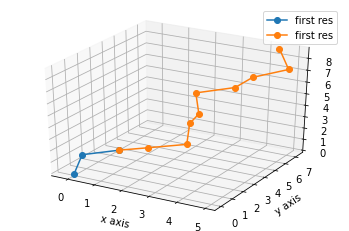

In [21]:
# print init of true chain to compare
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
start_res = (torch.cat([true_coords[:3, :],
                        true_coords[14:14+3],
                        true_coords[28:28+3],
                        true_coords[42:42+3]], dim=0) - true_coords[0, :]).numpy()

ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="first res")
ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="first res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")
# ax.plot(destin_first[:, 0], destin_first[:, 1], destin_first[:, 2],  "g-o", label="rotated second aa")
plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### True and predicted backbone

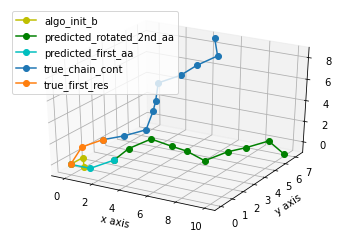

In [22]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
prev_res = coords[0, :3].numpy()
destin_first = rearrange(coords[:4, :3], 'l c d -> (l c) d').numpy()


ax.plot([1,0,0],[0,1,0],[0,0,0], 'y-o', label="algo_init_b")
ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(prev_res[:, 0], prev_res[:, 1], prev_res[:, 2],  "c-o", label="predicted_first_aa")

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### Rotate and show superimposed to confirm

In [23]:
def kabsch_torch(X, Y):
    """ Kabsch alignment of X into Y. 
        Assumes X,Y are both (Dims x N_points). See below for wrapper.
    """
    #  center X and Y to the origin
    X_ = X - X.mean(dim=-1, keepdim=True)
    Y_ = Y - Y.mean(dim=-1, keepdim=True)
    # calculate convariance matrix (for each prot in the batch)
    C = torch.matmul(X_, Y_.t())
    # Optimal rotation matrix via SVD - warning! W must be transposed
    V, S, W = torch.svd(C.detach())
    # determinant sign for direction correction
    d = (torch.det(V) * torch.det(W)) < 0.0
    if d:
        S[-1]    = S[-1] * (-1)
        V[:, -1] = V[:, -1] * (-1)
    # Create Rotation matrix U
    U = torch.matmul(V, W.t())
    # calculate rotations
    X_ = torch.matmul(X_.t(), U).t()
    # return centered and aligned
    return X_, Y_


In [24]:
flat_mask = rearrange(scaffolds["cloud_mask"], 'l d -> (l d)')
coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                              true_coords[:-14*padding_angles][flat_mask].t())
# create coord scaffolds
scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
# fill
scaff_coords_aligned[flat_mask] = coords_aligned.t()
scaff_labels_aligned[flat_mask] = labels_aligned.t()
# replace vars
coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned

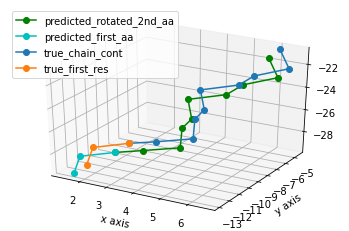

In [25]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
start_res    = torch.cat([labels_aligned[:3, :],
                        labels_aligned[14:14+3],
                        labels_aligned[28:28+3],
                        labels_aligned[42:42+3]], dim=0).numpy()
destin_first = torch.cat([coords_aligned[:3, :],
                        coords_aligned[14:14+3],
                        coords_aligned[28:28+3],
                        coords_aligned[42:42+3]], dim=0).numpy()

ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(destin_first[:3, 0], destin_first[:3, 1], destin_first[:3, 2],  "c-o", label="predicted_first_aa")

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### Save oriented to manually diagnose

In [26]:
# save predicted
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_aligned) 
sb.to_pdb("preds/predicted.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=labels_aligned) 
sb.to_pdb("preds/labels.pdb")
# go here: https://molstar.org/viewer/
# load chains and use superimposition tool